In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from KP import KnapsackProblem

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

import time

## Algorithm Comparisons

Notebook code for comparing the time and accuracy of various algorithms to solve the 0-1 Knapsack problem. 

Compared algorithms

- **Dynamical Programming Solution:**(`knapsack_dpV`)  Standard iterative solution to the problem which involves storing sub-problem solutions in matrix elements

- **Greedy Algorithm:**(`greedy`)  Algorithm based on computing the ratio of weights to volumes for each object and filling in the collection until the max weight is reached. 

- **Simulated Annealing:**(`simannl_knapsack`)   Involves representing the system computationally as a statistical physics one and then "annealing" the system to low temperatures. 

- **Exact $Z$ Algorithm:**(`exact_z_algorithm`) Algortihm based on computing the exact partition function recursively for a particular temperature

- **Large W Algorithm ($T=0$):**(`largeW_algorithm`)  Algorithm based on statistical physics representation of the system at $T=0$

- **Large W Algorithm ($T\neq0$):**(`largeW_algorithm`)  Algorithm based on statistical physics representation of the system at $T\neq0$

### Main Calculation

We now investigate how these accuracies vary as we change the number of items. We will ignore the brute force algorithm since it is so slow and take the dynamical programming solution to be our baseline of comparison (because it is exact). 

### Hard Instance: Profit-Ceiling Instance

In [1], Pisinger identifies four additional difficult instances of the knapsack problem. One such instance is the "profit-ceiling instance" whose main property is that all values are multiples of a given paramater $d$. The instance is generated by randomly (and uniformly) selecting weights in the interval $[1,R]$ and then setting the values to $p_j = d \lceil w_j/ d\rceil$.  

Pisinger notes that particularly difficult instancs appeared by choosing $d=3$. We will use this form of the knapsack problem to outline the performances of various algorithms including the algorithms outlined in the adjoining paper. 

[1] Pisinger, D. (2005). Where are the hard knapsack problems?. *Computers & Operations Research*, 32(9), 2271-2284.

In [2]:
# defining profit ceiling instance
v_ceiling = lambda w, d: np.array([d*int(np.ceil(welem/d)) for welem in w])

In [3]:
# test instance
KP_test = KnapsackProblem(weights = [1], values = [1], limit = 1)

# dictionary of algorithm names and functions
algo_name_dict = {'DP': KP_test.knapsack01_dpV,
                  'Greedy': KP_test.greedy,
                  'Annealing': KP_test.simann_knapsack,
                  'Exact Z': KP_test.exact_z_algorithm,
                  'Large W (T=0)': KP_test.largeW_algorithm,
                 'Large W (T/=0)': KP_test.largeW_algorithm}


for k, v in algo_name_dict.items():
    print(k)

DP
Greedy
Annealing
Exact Z
Large W (T=0)
Large W (T/=0)


In [63]:
power = 13 # max power
R = 10**2 
d = 3

# print intermediate results
verbose = True

# defining default dictionaries
time_list_name_dict = defaultdict(lambda: list())
accuracy_list_name_dict = defaultdict(lambda: list())

# list of degeneracies
degeneracy_list = list()
correlation_list = list()
W_norm_list = list()

# list of gamma vals and min v/w 
gamma_list = list()
min_v_w_list = list()

# start clock
start_clock0 = time.time()

for m in range(len(nelem_list)):
    
    # getting element
    nelem = nelem_list[m]
    
    # set seed
    np.random.seed(42)

    # Randomly choose the weight of each object
    weight_vec = np.random.randint(1,R+1,nelem)
    value_vec = v_ceiling(weight_vec, d=d)
    
    # Defining weight limit
    Wlimit = int(np.sum(weight_vec)/(2*np.sqrt(nelem)))  
    W_norm_list.append(Wlimit/np.mean(weight_vec))
    
    # knapsack instance
    KP_init = KnapsackProblem(weights = weight_vec, values = value_vec, limit = Wlimit)
    
    # dictionary of algorithm names and functions
    algo_name_dict = {'DP': KP_init.knapsack01_dpV,
                      'Greedy': KP_init.greedy,
                      'Annealing': KP_init.simann_knapsack,
                      r'Exact $Z$': KP_init.exact_z_algorithm,
                      r'Large $W$ ($T=0$)': KP_init.largeW_algorithm,
                     r'Large $W$ ($T\neq0$)': KP_init.largeW_algorithm
                     }    
    
    # degeneracy and correlation
    degeneracy_list.append(np.mean(list(Counter(weight_vec).values())))
    correlation_list.append(np.corrcoef(weight_vec, value_vec)[0,1])
    
    if verbose:
        print('## N = %s' % str(nelem))
        print('## Weight Limit: %.3f' % Wlimit)
        print('## Weight Limit/Avg Weight: %.3f' % (Wlimit/np.mean(weight_vec)))
        
        # average number of copies of each item
#         print('## Average degeneracy: %.3f' % np.mean(list(Counter(weight_vec).values()))  )
        print('## N_eff: %.3f' % (nelem/degeneracy_list[-1]))        
        print('## Correlation between values and weights: %.3f' % np.corrcoef(weight_vec, value_vec)[0,1])
        print('---')
        print('---')
        
    # collecting gamma_0 and min v/w values
    gamma_list.append(KP_init.gamma_calc())
    min_v_w_list.append(KP_init.greedy_ratio())
    
    if verbose:
        print('\nComputed gamma_0 value:',KP_init.gamma_calc())
        print('Computed min value-to-weight ratio:',KP_init.greedy_ratio(), '\n')
              
    for name, algo in algo_name_dict.items():

        # finding solution and computing time    
        start_clock = time.time()
        if name == r'Large $W$ ($T\neq0$)':
            soln = algo(T=1.0)
        else:    
            soln = algo()      
    
        if name == 'DP':
            true_value = np.dot(soln, value_vec)
            
        # getting runtime and accuracy
        time_list_name_dict[name].append(time.time()-start_clock)     
        accuracy_list_name_dict[name].append(1-np.abs(1-np.dot(soln, value_vec)/true_value)) 
        
        if verbose: 
            print('%s 1- |V_soln-V_exact|/V_exact: %.7f' % (name, accuracy_list_name_dict[name][-1]))
            print('%s Weight: %.3f' % (name, np.dot(soln, weight_vec)))
            print('%s computation time: %.7f' % (name, time_list_name_dict[name][-1]))
            print('---')
            
    if verbose: 
        print('Done with Round #%i!' % (m+1))
        print('Total elapsed ime so far: %.7f sec' % (time.time()-start_clock0))
        print('')
        print('')
        
neff_unique = np.array(nelem_list)/np.array(degeneracy_list)        

## N = 8
## Weight Limit: 85.000
## Weight Limit/Avg Weight: 1.405
## N_eff: 8.000
## Correlation between values and weights: 1.000
---
---

Computed gamma_0 value: 1.0327868852459017
Computed min value-to-weight ratio: 1.0327868852459017 

DP 1- |V_soln-V_exact|/V_exact: 1.0000000
DP Weight: 82.000
DP computation time: 0.0002849
---
Greedy 1- |V_soln-V_exact|/V_exact: 0.8214286
Greedy Weight: 67.000
Greedy computation time: 0.0000281
---
Stopping annealing because error tolerance was reached
Annealing 1- |V_soln-V_exact|/V_exact: 0.9285714
Annealing Weight: 76.000
Annealing computation time: 0.1380489
---
Exact $Z$ 1- |V_soln-V_exact|/V_exact: 1.0000000
Exact $Z$ Weight: 82.000
Exact $Z$ computation time: 0.0018868
---
Large $W$ ($T=0$) 1- |V_soln-V_exact|/V_exact: 0.6428571
Large $W$ ($T=0$) Weight: 52.000
Large $W$ ($T=0$) computation time: 0.0009530
---
Large $W$ ($T\neq0$) 1- |V_soln-V_exact|/V_exact: 0.0000000
Large $W$ ($T\neq0$) Weight: 0.000
Large $W$ ($T\neq0$) computation ti

Large $W$ ($T\neq0$) 1- |V_soln-V_exact|/V_exact: 0.1226994
Large $W$ ($T\neq0$) Weight: 64.000
Large $W$ ($T\neq0$) computation time: 1.4883482
---
Done with Round #8!
Total elapsed ime so far: 15.5671728 sec


## N = 2048
## Weight Limit: 1134.000
## Weight Limit/Avg Weight: 22.621
## N_eff: 100.000
## Correlation between values and weights: 1.000
---
---

Computed gamma_0 value: 1.125
Computed min value-to-weight ratio: 1.125 

DP 1- |V_soln-V_exact|/V_exact: 1.0000000
DP Weight: 1134.000
DP computation time: 0.7682760
---
Greedy 1- |V_soln-V_exact|/V_exact: 1.0000000
Greedy Weight: 1132.000
Greedy computation time: 0.0028071
---
Annealing 1- |V_soln-V_exact|/V_exact: 0.8389831
Annealing Weight: 1134.000
Annealing computation time: 1.8440249
---
Exact $Z$ 1- |V_soln-V_exact|/V_exact: 0.8919492
Exact $Z$ Weight: 1134.000
Exact $Z$ computation time: 16.3868861
---
Large $W$ ($T=0$) 1- |V_soln-V_exact|/V_exact: 0.7457627
Large $W$ ($T=0$) Weight: 812.000
Large $W$ ($T=0$) computation t

In [7]:
neff_unique = np.array(nelem_list)/np.array(degeneracy_list)
neff_unique

array([  8.,  15.,  27.,  45.,  70.,  94.,  99., 100., 100.])

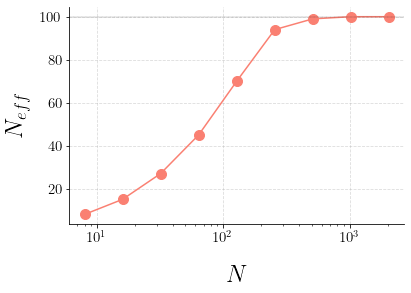

In [60]:
plt.plot(nelem_list, neff_unique, color = 'salmon', markersize = 10, marker = 'o')

ax = plt.subplot(111)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.grid(alpha = 0.45, linestyle = '--')
plt.xscale('log')
plt.xticks(fontsize = 15)
plt.axhline(y=100, color = 'k', linestyle = 'dashed', linewidth = 0.25)
plt.yticks(fontsize = 15)
plt.xlabel(r'$N$', fontsize = 24, labelpad=20.0)
plt.ylabel(r'$N_{eff}$', fontsize = 24, labelpad=10.0)
plt.show()

In [62]:
np.array(W_norm_list)

array([ 1.40495868,  1.99134199,  2.81359906,  3.99756246,  5.64646782,
        7.9907056 , 11.2944111 , 15.98627894, 22.62057681])

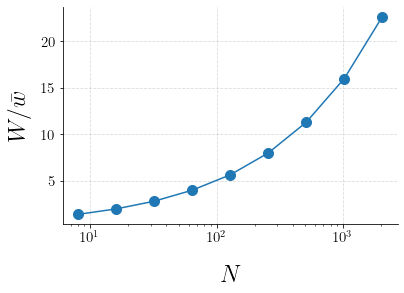

In [61]:
plt.plot(nelem_list, np.array(W_norm_list), markersize = 10, marker = 'o')

ax = plt.subplot(111)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.grid(alpha = 0.45, linestyle = '--')
plt.xscale('log')
plt.xticks(fontsize = 15)
# plt.axhline(y=100, color = 'k', linestyle = 'dashed', linewidth = 0.25)
plt.yticks(fontsize = 15)
plt.xlabel(r'$N$', fontsize = 24, labelpad=20.0)
plt.ylabel(r'$W/\bar{w}$', fontsize = 24, labelpad=10.0)
plt.show()

## Plots

### Accuracy vs $N$

In [15]:
# dictionary of algorithm names and functions
marker_name_dict = {
                    'DP': 's',  
                 'Greedy': 'o',
                 'Annealing': '^',
                r'Exact $Z$': 'h',
                r'Large $W$ ($T=0$)': 'P',
                r'Large $W$ ($T\neq0$)':'p'}

# dictionary of algorithm names and functions
color_name_dict = {
                    'DP': 'blue',  
                 'Greedy': 'green',
                 'Annealing': 'darkorange' ,
                r'Exact $Z$': 'gold',
                r'Large $W$ ($T=0$)': 'red',
                r'Large $W$ ($T\neq0$)':'slategrey'}

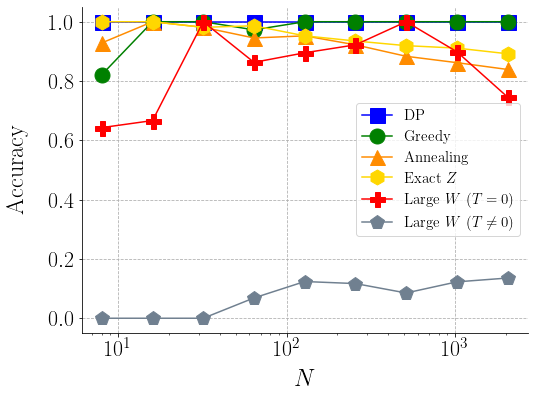

In [30]:
plt.figure(figsize = (8,6))

ax = plt.subplot(111)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for name, accuracy_ in accuracy_list_name_dict.items():

    nums = nelem_list
    plt.plot(nums, np.array(accuracy_), marker = marker_name_dict[name], color = color_name_dict[name], linestyle = '-', label = r'%s' % name, markersize = 15)

plt.grid(alpha = 1, linestyle = '--')
plt.xscale('log')
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.xlabel(r'$N$', fontsize = 24, labelpad=10)
plt.ylabel(r'Accuracy', fontsize = 24, labelpad=20.0)
plt.legend(loc = 'best', fontsize = 15)

# plt.savefig('/Users/mobolajiwilliams/Dropbox/0Tex_Files_Mac/2020_largeN_knapsack_problem/LaTeX_JStatPhys/vratio_vs_num_profit_ceiling.png', dpi = 100, bbox_inches='tight' )

plt.show()

### Time vs $N$

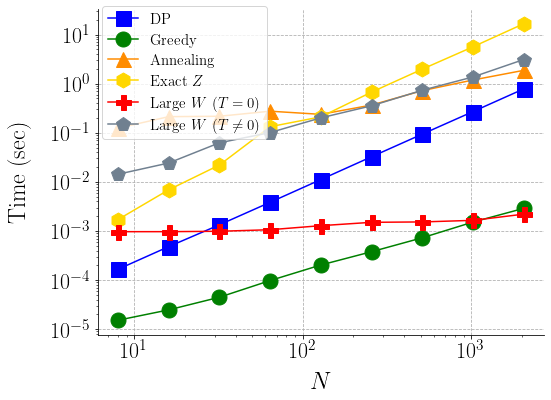

In [29]:
plt.figure(figsize = (8,6))

ax = plt.subplot(111)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for name, time_ in time_list_name_dict.items():

    nums = nelem_list
    plt.plot(nums, np.array(time_), marker_name_dict[name], color = color_name_dict[name],linestyle = '-', label = r'%s' % name, markersize = 15)


plt.grid(alpha = 1, linestyle = '--')
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r'$N$', fontsize = 24, labelpad=10)
plt.ylabel(r'Time (sec)', fontsize = 24, labelpad=20.0)
plt.legend(loc = (.01,.6), fontsize = 15)

# plt.savefig('/Users/mobolajiwilliams/Dropbox/0Tex_Files_Mac/2020_largeN_knapsack_problem/LaTeX_JStatPhys/time_vs_num_profit_ceiling.png', dpi = 100, bbox_inches='tight' )

plt.show()

### Time vs Accuracy

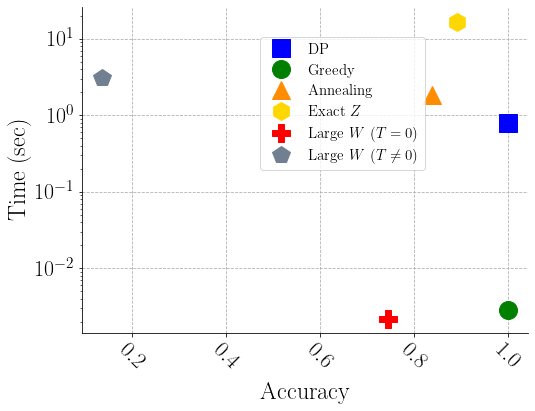

In [28]:
## accuracy-time scatter plot

plt.figure(figsize = (8,6))

ax = plt.subplot(111)

for name, _ in accuracy_list_name_dict.items():
    accuracy_ = accuracy_list_name_dict[name][-1]
    time_ = time_list_name_dict[name][-1]

    plt.plot([accuracy_], [time_], marker_name_dict[name], color = color_name_dict[name], label = r'%s' % name, markersize = 18)


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.grid(alpha = 1, linestyle = '--')
plt.yscale('log')
plt.xticks(fontsize = 22, rotation = -45)
plt.yticks(fontsize = 22)
plt.xlabel(r'Accuracy', fontsize = 24, labelpad=10)
plt.ylabel(r'Time (sec)', fontsize = 24)
plt.legend(loc = (0.4, 0.5), fontsize = 15)

# plt.savefig('/Users/mobolajiwilliams/Dropbox/0Tex_Files_Mac/2020_largeN_knapsack_problem/LaTeX_JStatPhys/time_vs_vratio_profit_ceiling.png', dpi = 100, bbox_inches='tight' )

plt.show()

## Tabulated Results for $N = 2048$

Here we tabulate the performance results for all algorithms applied to the profit-ceiling instance with N=2048 items. 

In [26]:
# testing 
algo_name_list = ['DP','Greedy','Annealing', r'Exact $Z$', r'Large $W$ ($T=0$)', r'Large $W$ ($T\neq0$)']

# defining empty results dictionary
results_name_dict = {'runtime': ['runtime']+[0]*6,
                    'error': ['error']+[0]*6,}

In [27]:
for j in range(6):
    # name of algorithm
    name = algo_name_list[j]
    
    # calculating accuracy and runtime
    accuracy, runtime = accuracy_list_name_dict[name][-1], time_list_name_dict[name][-1]
    
    # filling in error and runtime values
    results_name_dict['error'][j+1] = 1-accuracy
    results_name_dict['runtime'][j+1] = runtime       

In [28]:
from tabulate import tabulate
# creating table of results
tabular_results = []
for k, v in results_name_dict.items():
    tabular_results.append(v) 

print(tabulate(tabular_results, ["", "DP", "Greedy", "Annealing", "Exact Z", "T=0", "T/=0"], tablefmt="grid"))

+---------+-------+------------+-------------+--------------+------------+----------+
|         |    DP |     Greedy |   Annealing |      Exact Z |        T=0 |     T/=0 |
+=========+=======+============+=============+==============+============+==========+
| runtime | 35.76 | 0.00298381 |   0.136705  | 829.603      | 0.00315309 | 2.952    |
+---------+-------+------------+-------------+--------------+------------+----------+
| error   |  0    | 0          |   0.0147652 |   0.00567891 | 0.00647396 | 0.762281 |
+---------+-------+------------+-------------+--------------+------------+----------+


## Averag Normed Ratio Difference

The normed ratio difference is defined as 

\begin{equation}
    \text{norm. ratio diff.} = \frac{|\gamma_0 - v_\alpha/w_\alpha|}{\gamma_0},
    \label{eq:ratio_diff}
\end{equation}

where $\gamma_0$ is determined from the zero-temperature algorithm and $v_{\alpha}/w_{\alpha}$ is the minimum ratio determined from the standard greedy algorithm. We compute the average of the normed ratio differences for all of the $N$ in the above plots. 

In [31]:
# array conversion
gamma_array, min_v_w_array  = np.array(gamma_list), np.array(min_v_w_list)
# computing normed ratio difference
print('Average of Norm. Ratio. Diff: ', np.mean(np.abs(gamma_list - min_v_w_list)/gamma_list))

Average of Norm. Ratio. Diff:  9.75086394901416e-17
